In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_file = "/content/drive/MyDrive/cloud/pics.zip"
output_directory = "/content/drive/MyDrive/cloud/company"
# password = "SWIMSEG(JSTARS2017)"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # zip_ref.setpassword(bytes(password, 'utf-8'))  # Set the password for the zip file
    zip_ref.extractall(output_directory)

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Swimseg Dataset
class Swimseg(Dataset):
    def __init__(self, path_img, path_seg, transforms=None):
        self.path_img = path_img
        self.path_seg = path_seg
        self.image_files = sorted(os.listdir(path_img))
        self.segmentation_files = sorted(os.listdir(path_seg))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path_img, self.image_files[idx])
        seg_path = os.path.join(self.path_seg, self.segmentation_files[idx])

        img = Image.open(img_path).convert('RGB')
        seg = Image.open(seg_path).convert('L')  # Assuming segmentation images are grayscale

        if self.transforms:
            img, seg = self.transforms(img, seg)

        return img, seg


def swimseg_transforms(img, seg):
    # Apply your swimseg transformations here.
    # Make sure to apply the same transformations to both the input image and the segmentation image.
    transform_img = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    transform_seg = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    img = transform_img(img)
    seg = transform_seg(seg)

    return img, seg

class Company(Dataset):
    def __init__(self, path_img, transforms=None):
        self.path_img = path_img
        self.image_files = sorted(os.listdir(path_img))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path_img, self.image_files[idx])

        img = Image.open(img_path).convert('RGB')

        if self.transforms:
            img = self.transforms(img)

        return img

def company_transforms(img):
    # Apply your custom transformations here.
    # Make sure to apply the same transformations to both the input image and the segmentation image.
    transform_img = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    img = transform_img(img)

    return img


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


In [ ]:
path_img = '/content/drive/MyDrive/cloud/swimseg/images'
path_seg = '/content/drive/MyDrive/cloud/swimseg/GTmaps'

# Initialize the dataset with the image and segmentation paths, and the custom transformations
dataset = Swimseg(path_img, path_seg, transforms=swimseg_transforms)

# Example usage with DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
path_company = "/content/drive/MyDrive/cloud/company/pics"
company_dataset = Company(path_company, transforms=company_transforms)
company_dataloader = torch.utils.data.DataLoader(company_dataset, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# imshow
def imshow(x, y):
    to_pil = ToPILImage()
    img_pil_x, img_pil_y = to_pil(x), to_pil(y)

    # Create a new figure
    plt.figure()

    # Create the first subplot and display the first image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first image
    plt.imshow(img_pil_x)
    plt.axis('off')  # Hide axis

    # Create the second subplot and display the second image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second image
    plt.imshow(img_pil_y)
    plt.axis('off')  # Hide axis

    plt.show()

In [ ]:
import torch
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
import numpy as np


# Split the dataset into train and test subsets
split_ratio = 0.9
train_size = int(split_ratio * len(dataset))
test_size = len(dataset) - train_size

# Generate indices for train and test
indices = np.random.permutation(len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create train and test datasets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")


Number of samples in train_dataset: 911
Number of samples in test_dataset: 102


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Set hyperparameters
learning_rate = 1e-4
num_epochs = 10
batch_size = 8

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # change the loss function
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # add a learning rate scheduler

# Train the network
accumulation_steps = 4
optimizer.zero_grad()  # Reset gradients at the beginning of each accumulation loop

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).squeeze()

        outputs = net(inputs).sum(dim=1)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps  # Normalize the loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # Update the model parameters every accumulation_steps
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

    scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


#     # Evaluate on the validation set and save the best model
#     iou = evaluate_iou(net, val_loader) # assuming evaluate_iou is a function you define to calculate IoU
#     if iou > best_iou:
#         best_iou = iou
#         torch.save(net.state_dict(), "best_model.pth")

# print("Finished fine-tuning")

# # Load the best model for evaluation
# net.load_state_dict(torch.load("best_model.pth"))

# # Evaluate the network using the metric of your choice
# evaluate(net, test_loader) # assuming evaluate is a function you define to calculate your chosen metric


Epoch 1, Loss: 0.43525351008825136
Epoch 2, Loss: 0.3060921463265754
Epoch 3, Loss: 0.2932759787429843
Epoch 4, Loss: 0.2767699945129846
Epoch 5, Loss: 0.2740926537335965
Epoch 6, Loss: 0.25979102638206986
Epoch 7, Loss: 0.2583246342184251
Epoch 8, Loss: 0.25048609064859256
Epoch 9, Loss: 0.25470803965602007
Epoch 10, Loss: 0.2535347522873628


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


gt, fine-tuned


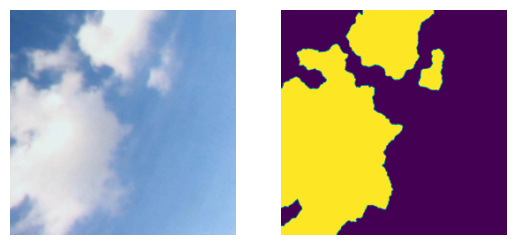

gt, pre-trained


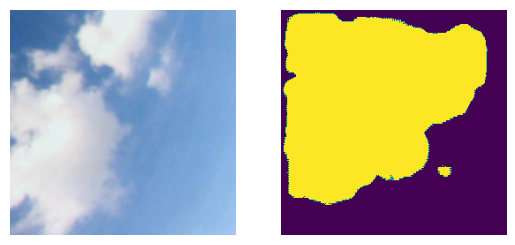

In [ ]:
net1 = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
net1 = net1.to(device)
itr1 = iter(test_loader)
x1, y1 = next(itr1)
x1, y1  = x1.to(device), y1.to(device)
y_pred1 = net1(x1)


print("gt, fine-tuned")
imshow(x1[0], y1[0])
print("gt, pre-trained")
imshow(x1[0], y_pred1[0].sum(dim=0).round())